# Question 5
## Assignment I - Advanced Econometrics II

In [1464]:
%reload_ext jupyternotify

<IPython.core.display.Javascript object>

In [755]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

In [1547]:
from scipy import stats
from sklearn import datasets, linear_model

In [1548]:
np.random.seed(11012020)

### Data generation process

We are going to generate random data of $N$ individuals with $k$ features from a multivariate normal. 

\begin{align}
\Sigma &\in R^{k \times k} \\
X &\sim N(0, \Sigma) \\
y_i &= \beta \cdot X_i + \epsilon_i, \ \epsilon_i \sim N(0, 1) 
\end{align}

Also a probability of treatement $p(X_i) = P(D_i = 1 \mid X_i)$ as follows, 

\begin{align}
    p(X) = logistic(X \cdot \gamma + \eta), \ \eta \sim N(0, \sigma^2_{\eta}) \\
\end{align}

where

\begin{align}
logistic(X) = (1 + exp(-X))^{-1} 
\end{align}

In [1629]:
N = 1_000
k = 2
variance_p = 4
gamma = np.array([0.8, 0.3])
beta = np.array([1, 5])

In [1630]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [1631]:
def generate_data(N, k, beta = beta, gamma = gamma, sigma_eta = 2):
    
    cov = sklearn.datasets.make_spd_matrix(k)
    mean = np.zeros(N)
    X = np.random.multivariate_normal(np.zeros(k), cov, N)
    
    noise = np.random.normal(0, 1, N)        
    y = X@beta + noise
    
    prob_noise = np.random.normal(0, sigma_eta, N)
    prob_vec = logistic(X@gamma + prob_noise)
        
    D = (np.random.uniform(0, 1, N) < prob_vec).round()
    
    return X, D, y

In [1632]:
X, D, y = generate_data(N, k, sigma_eta=variance_p)

### Propensity score estimation

Next we are going to fit a logit to estimate the propensity score, 

\begin{align}
\hat{p}(X_i) = \frac{1}{1 + exp(-\gamma \cdot(X_i - \overline{X}_i))} 
\end{align}

In [1633]:
logit = linear_model.LogisticRegression(solver='lbfgs')

In [1634]:
logit.fit_intercept = False
model = logit.fit(X, D)

In [1635]:
estimated_p = model.predict_proba(X)[:, 0]
ordered_p_idx = np.argsort(estimated_p)

We can look at the distribution of the $p(X_i)$

In [1636]:
def plot_p(sigma):
    X, D, y = generate_data(N, k, sigma_eta=sigma)
    logit = linear_model.LogisticRegression(solver='lbfgs')
    logit.fit_intercept = False
    model = logit.fit(X, D)
    estimated_p = model.predict_proba(X)[:, 0]
    ordered_p_idx = np.argsort(estimated_p)
    
    plt.figure(figsize=(14,8))
    ax = sns.distplot(estimated_p, bins=15, kde=False)

    ax.set(xlabel="p(X)")
    ax.set_xlim(0, 1)

    for boundary in ((n+1) / n_strata for n in range(n_strata - 1)):
        ax.axvline(boundary, ls='--', c='r')

    plt.show()

### Startification

Group data in *strata*, given by similar propensity scores

In [1747]:
def split_prob_equally(sorted_prob, strata = 5):
    
    splits = [(n+1)/strata for n in range(strata - 1)]
    index_at = sorted_prob.searchsorted(splits)
    
    return np.split(sorted_prob, index_at)

In [1637]:
def stratify(X, D, y, permutation, strata = 5):
    N, k = X.shape
    
    ordered_X = X[permutation, :]
    ordered_y = y[permutation]
    ordered_D = D[permutation]
    
    strata = zip(*(np.split(dataset, strata) for dataset in [ordered_X, ordered_D, ordered_y]))
    
    return list(strata)

In [1638]:
n_strata = 5

strata = stratify(X, D, y, ordered_p_idx, strata=n_strata)

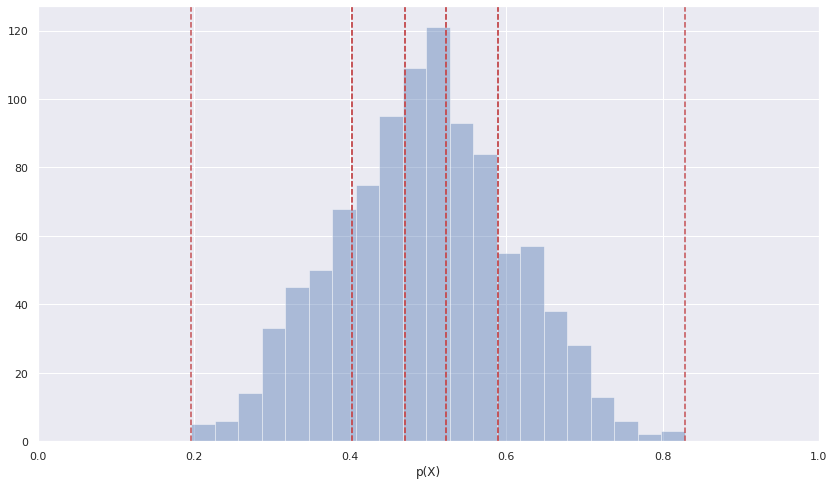

In [1717]:
plt.figure(figsize=(14,8))
ax = sns.distplot(estimated_p, kde=False)

ax.set(xlabel="p(X)")
ax.set_xlim(0, 1)

for prob_split in np.split(estimated_p[ordered_p_idx], n_strata):
    ax.axvline(prob_split[0], ls='--', c='r')
    ax.axvline(prob_split[-1], ls='--', c='r')

plt.show()

In [1640]:
samples = (len(stratum[1]) for stratum in strata)

print('Sample per stratum:', ', '.join((str(i) for i in samples)))

Sample per stratum: 200, 200, 200, 200, 200


### Average Treatement Effect, startified

Now we are going to estimate the average treatement effect as follows.

Let $S$ be the strata, $j \in S$, and $N_j$ the number of observations in the stratum, then

\begin{align}
\Delta_j &= \overline{y}_j(1) - \overline{y}_j(0) \\
\Delta &= \sum_{j}^{S} \frac{N_j}{N} \cdot \Delta_j
\end{align}

and the variance of the $j$ stratum and $k$ treatement group as,

\begin{align}
V_{j,k} &= \frac{S^2_{j,k}}{N_{j,k}} \\
V &= \sum_{j}^{S} \frac{N_j}{N} \cdot  (V_{j,0} + V_{j,1})
\end{align}

In [1641]:
def ate(strata, pop_N):
    delta = 0
    variance = 0
    
    N_strata = len(strata)
    
    for X, D, y in strata:
            
        N = y.shape[0]
        
        if N == 0:
            continue
        
            
        stratum_weight =  N / pop_N 
        
        N_squared = np.square(N)    
        
        y_1 = y[np.where(D == 1)[0]]
        y_0 = y[np.where(D == 0)[0]]
        
        N_0 = y_0.shape[0]
        N_1 = y_1.shape[0]
        
        delta_j =  (np.mean(y_1)  - np.mean(y_0))
        
        variance_j = (np.var(y_0)/N_0) + (np.var(y_1)/N_1)
        
        delta += (delta_j  * stratum_weight)
        variance += (variance_j *  np.square(stratum_weight))
                
    return delta, variance
        

In [1642]:
delta_strata, var_strata = ate(strata, N)

In [1643]:
print(f'Not using strata, delta={delta} and var={variance}')
print(f'Using strata, delta={delta_strata} and var={var_strata}')

Not using strata, delta=1.4854573810117322 and var=3.932469260215357
Using strata, delta=0.019986651747587875 and var=0.05005852578912433


### Monte Carlo simulation

The following Monte Carlo simulation tries and find the effect of increasing $\sigma^2_{\eta}$ on the test,

\begin{align}
H_0&: \Delta_{ATE} = 0\\
H_1&: \Delta_{ATE} \neq 0
\end{align}

In particular increasing $\sigma^2_{\eta}$, increases the noise in $p(X_i)$ hence making the strata selection less dependent on $X_i$. We expect therefore to reject $H_0$ more often if $\sigma^2_{\eta}$ is relatively low and to not reject otherwise.

We are going to simulate with $\sigma^2_{\eta, i} \in S$, where $S$ is a geometrically spaced sequence of order 15, between 1 and 10.

In [1692]:
sigma_nus = np.geomspace(0.2, 25, 30)

The single `estimate` function simply combines the whole procedure we have seen above.

In [1763]:
def estimate(N, k, variance_p, n_strata = 5):
    X, D, y = generate_data(N, k, sigma_eta=variance_p)
    
    # standard
    delta = np.mean(y[np.where(D == 1)[0]]) - np.mean(y[np.where(D == 0)[0]])
    variance = np.var(y[np.where(D == 1)[0]]) + np.var(y[np.where(D == 0)[0]])
    
    
    # stratification
    logit = linear_model.LogisticRegression(solver='lbfgs')
    logit.fit_intercept = False
    model = logit.fit(X, D)
    
    estimated_p = model.predict_proba(X)[:, 0]
    ordered_p_idx = np.argsort(estimated_p)
    
    strata = stratify(X, D, y, ordered_p_idx, n_strata)
    
    delta_strata, var_strata = ate(strata, N)
    
    prob_bins = split_prob_equally(estimated_p[ordered_p_idx], n_strata)
    _, p_gof = stats.chisquare([b.shape[0] for b in prob_bins])
        
    
    return delta, variance, delta_strata, var_strata, p_gof

In [1769]:
def test_against_zero(mean, std, t):
    upper = mean + t*std
    lower = mean - t*std
    
    return int(upper < 0 or lower > 0)
    

The initialization parameters are

In [1770]:
params = {
    'N': 5_000,
    'k': 2,
    'p_variances': sigma_nus,
    'iterations': 1_000,
    'alpha': 0.1
}

The simulation works as follows: for every $\sigma^2_{\eta, i} \in$ `sigma_nus`, it computes the $\Delta_{ATE, stratified}$ and $Var[\Delta_{ATE, stratified}]$, as shown before and applies the aforementioned tests with $\alpha = 0.05$. 

This is done `params['iterations']` times and the amount of rejections are recorded. Then, let `strata_rejections` be the vector with the number of rejcetions, by computing `strata_rejections / params['iterations']`, we can find the empirical test size for every $\sigma^2_{\eta, i}$, and compare it with $alpha$.

In [1773]:
def monte_carlo_test(p_variances = [], N = 10_000, k = 10, iterations = 1, alpha=0.05, verbose = False):
    
    strata_rejections = []
    normal_rejections = []
    p_gof_by_var = []
    
    t = -scistat.norm.ppf(alpha)
    
    for n, p_var in enumerate(p_variances):
                
        if verbose:
            print(f'Simulating {n+1}/{len(p_variances)}:')
            
        out_of_CI_normal = 0
        out_of_CI_strata = 0
        sum_p_gof = 0
        
        for i in range(iterations):
            if verbose:
                print(f'--> Iteration {i+1}/{iterations}', end='\r')
            
            delta, var, delta_strata, var_strata, p_gof = estimate(N, k, p_var, n_strata=5)
            
            reject = test_against_zero(delta, np.sqrt(var), t)
            reject_strata = test_against_zero(delta_strata, np.sqrt(var_strata), t)
            
            out_of_CI_normal += reject
            out_of_CI_strata += reject_strata
            sum_p_gof += p_gof
                        
            
        normal_rejections.append(out_of_CI_normal)
        strata_rejections.append(out_of_CI_strata)
        p_gof_by_var.append(sum_p_gof/iterations)
        
        if verbose:
            print('\n')
        
    return normal_rejections, strata_rejections, p_gof_by_var

In [1774]:
normal_rejections, strata_rejections, p_gof_by_var = monte_carlo_test(**params, verbose=False)

### Results

From the below graph it is clear that the empirical size (i.e. the number of rejections out of the number of iterations) converges towards $\alpha$, hence the uncertainty in the propensity score can lead to a higher probability of Type I error than intended. We can also check the Pearson Goodness-of-Fit test on the distribution of $p(X)$

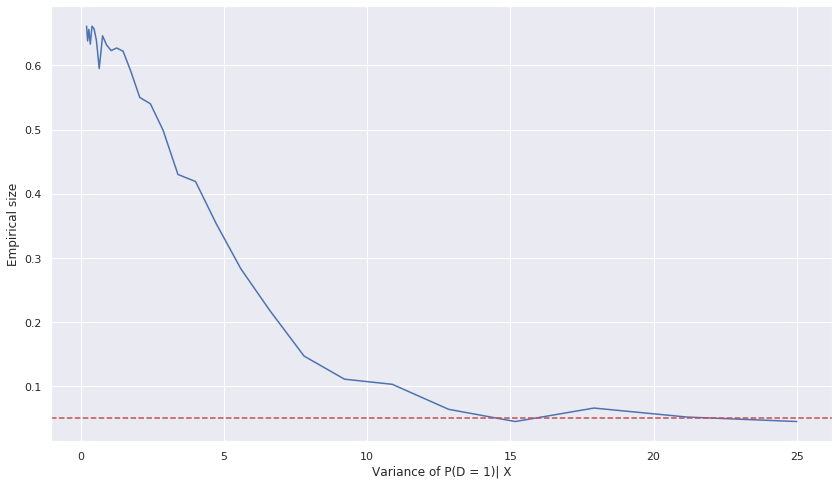

In [1775]:
plt.figure(figsize=(14,8))
ax = sns.lineplot(x=sigma_nus, y=empirical_size)

ax.axhline(params['alpha']/2, ls='--', c='r')
ax.set(xlabel='Variance of P(D = 1)| X', ylabel='Empirical size')

plt.show()

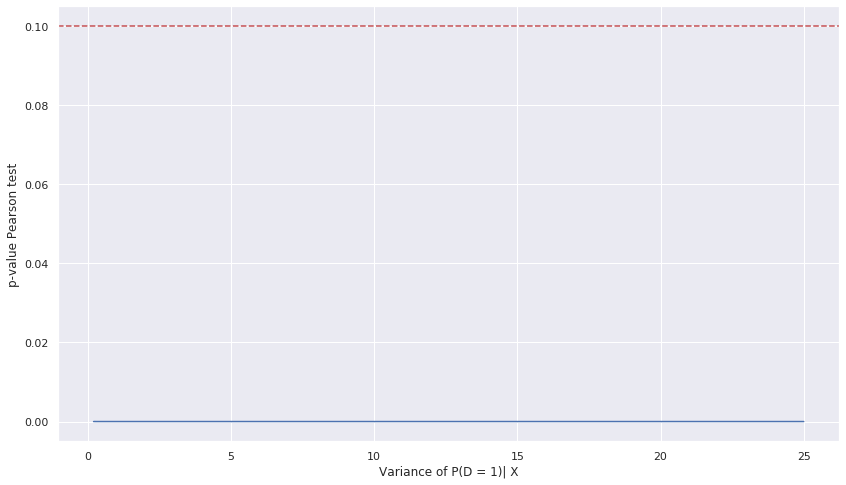

In [1776]:
plt.figure(figsize=(14,8))
ax = sns.lineplot(x=sigma_nus, y=p_gof_by_var)

ax.axhline(params['alpha'], ls='--', c='r')
ax.set(xlabel='Variance of P(D = 1)| X', ylabel='p-value Pearson test')

plt.show()

In [1777]:
%notify

<IPython.core.display.Javascript object>